In [1]:
# imports
import boundarytools
import numpy as np

import json
from urllib.request import urlopen

## Load in a set of country boundaries from NaturalEarth and GADM

In [2]:
# set params
country = 'AGO' #'CYP', 'TUN' #'BDI' #'BLR' #'LUX' #'CHE'
level = 3
ignore_sources = [] #['geoBoundaries (Open)', 'geoBoundaries (Authoritative)']

## Loop all pairs of sources and calculate

available sources: dict_keys(['GADM v3.6', 'geoBoundaries (Open)'])

GADM v3.6 vs GADM v3.6


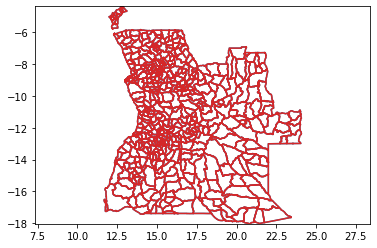

{'equality': 1.0, 'within': 1.0, 'contains': 1.0}

GADM v3.6 vs geoBoundaries (Open)


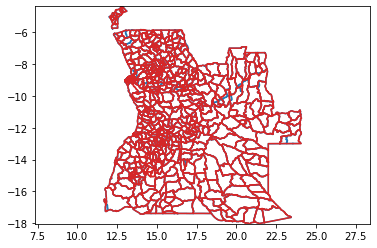

{'equality': 0.0, 'within': 0.0, 'contains': 0.0}

geoBoundaries (Open) vs GADM v3.6


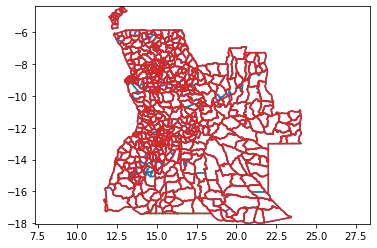

{'equality': 0.0, 'within': 0.0, 'contains': 0.0}

geoBoundaries (Open) vs geoBoundaries (Open)


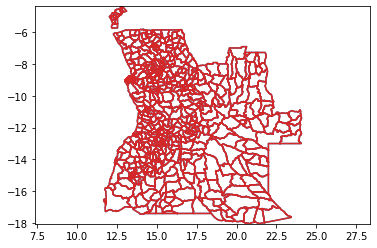

{'equality': 1.0, 'within': 1.0, 'contains': 1.0}


In [3]:
import io
import cProfile, pstats

profiler = cProfile.Profile()
profiler.enable()

# first get all possible sources
sourcedict = boundarytools.utils.find_geocontrast_sources(country, level)
print('available sources:', sourcedict.keys())

# next loop all pairs of sources
source_maps_matrix = {}
source_results_matrix = {}
for source1,url1 in sourcedict.items():
    if source1 in ignore_sources: continue
    if 'geoBoundaries' in source1:
        url1 = url1.replace('.topojson','.geojson')
        coll1 = boundarytools.utils.load_geojson_url(url1, load_shapely=True)
    else:
        coll1 = boundarytools.utils.load_topojson_url(url1, load_shapely=True)

    # simplify
    for feat in coll1['features']:
        feat['shapely'] = feat['shapely'].buffer(0).simplify(0.01)
    
    source_maps_row = {}
    source_results_row = {}
    
    for source2,url2 in sourcedict.items():
        #if source2 == source1: continue
        if source2 in ignore_sources: continue
        print('')
        print(source1, 'vs', source2)
        if 'geoBoundaries' in source2:
            url2 = url2.replace('.topojson','.geojson')
            coll2 = boundarytools.utils.load_geojson_url(url2, load_shapely=True)
        else:
            coll2 = boundarytools.utils.load_topojson_url(url2, load_shapely=True)
            
        # simplify
        for feat2 in coll2['features']:
            feat2['shapely'] = feat2['shapely'].buffer(0).simplify(0.01)
            
        # show
        import matplotlib.pyplot as plt
        boundarytools.utils.show_datasets(coll1, coll2)
        plt.show()
            
        # calc simil stats
        def similarity(feat1, feat2):
            isec_area = feat1['shapely'].intersection(feat2['shapely']).area
            union_area = feat1['shapely'].union(feat2['shapely']).area
            equality = isec_area / union_area
            within = isec_area / feat1['shapely'].area
            contains = isec_area / feat2['shapely'].area
            stats = {'equality':equality, 'within':within, 'contains':contains}
            print(stats)
            return stats
        feat1,feat2 = coll1['features'][0], coll2['features'][0]
        source_results_row[source2] = similarity(feat1, feat2)
        # first from persepctive of coll1
        #feat1,feat2 = coll1['features'][0], coll2['features'][0]
        #feat1['similarity'] = similarity(feat1, feat2)
        # then from perspective of coll2
        #feat2['similarity'] = similarity(feat2, feat1)
        
    source_results_matrix[source1] = source_results_row

In [4]:
# convert results matrix dicts to list of lists
sources = sourcedict.keys()
etable = [] # equality
wtable = [] # within
ctable = [] # contains
etable.append([''] + list(sources))
wtable.append([''] + list(sources))
ctable.append([''] + list(sources))
for source1 in list(sources):
    erow = [source1]
    wrow = [source1]
    crow = [source1]
    for source2 in list(sources):
        stat = source_results_matrix[source1][source2]['equality']
        cell = '<span>{:.4f}%</span>'.format(stat*100)
        erow.append(cell)
        
        stat = source_results_matrix[source1][source2]['within']
        cell = '<span>{:.4f}%</span>'.format(stat*100)
        wrow.append(cell)
        
        stat = source_results_matrix[source1][source2]['contains']
        cell = '<span>{:.4f}%</span>'.format(stat*100)
        crow.append(cell)
        
    etable.append(erow)
    wtable.append(wrow)
    ctable.append(crow)

# show equality matrix
print('source equality table for {}-ADM{}'.format(country,level))
from IPython.display import HTML, display
htmlstring = '<table>'
for row in etable:
    htmlstring += '<tr>'
    for cell in row:
        htmlstring += '<td style="text-align:center">'
        htmlstring += cell
        htmlstring += '</td>'
    htmlstring += '</tr>'
htmlstring += '</table>'
display(HTML(htmlstring))

# show within matrix
print('source within table for {}-ADM{}'.format(country,level))
from IPython.display import HTML, display
htmlstring = '<table>'
for row in wtable:
    htmlstring += '<tr>'
    for cell in row:
        htmlstring += '<td style="text-align:center">'
        htmlstring += cell
        htmlstring += '</td>'
    htmlstring += '</tr>'
htmlstring += '</table>'
display(HTML(htmlstring))

# show contains matrix
print('source contains table for {}-ADM{}'.format(country,level))
from IPython.display import HTML, display
htmlstring = '<table>'
for row in ctable:
    htmlstring += '<tr>'
    for cell in row:
        htmlstring += '<td style="text-align:center">'
        htmlstring += cell
        htmlstring += '</td>'
    htmlstring += '</tr>'
htmlstring += '</table>'
display(HTML(htmlstring))

source equality table for AGO-ADM3


,GADM v3.6,geoBoundaries (Open)
GADM v3.6,100.0000%,0.0000%
geoBoundaries (Open),0.0000%,100.0000%


source within table for AGO-ADM3


,GADM v3.6,geoBoundaries (Open)
GADM v3.6,100.0000%,0.0000%
geoBoundaries (Open),0.0000%,100.0000%


source contains table for AGO-ADM3


,GADM v3.6,geoBoundaries (Open)
GADM v3.6,100.0000%,0.0000%
geoBoundaries (Open),0.0000%,100.0000%


In [5]:
source_results_matrix.keys()

dict_keys(['GADM v3.6', 'geoBoundaries (Open)'])

## Some notes
The calculation is a simple two-term equation: probability of falling in feat2 given that we are sampling from feat1 * their equality metric. This can also be written as the intersection-within-feat1 metric * their equality metric. The equality metric is always the same regardless of comparison order (which side of the matrix). 

Now the row entries are always from the perspective of feat1, while the column entries are always from the perspective of feat2. Since equality is symmetric around the diagonal, then the only reason the calculated upper and lower diagonal are different is because the within metric is different around the diagonal. In other words, the asymmetry of the calculation is driven entirely by the within metric, along with a scaling factor based on the equality metric. 

Because we know that the within metric and contains metric are each others inverse when flipping around the diagonal, ie within = containsFlipped and contains = withinFlipped. This means that all entries in the upper diagonal can be interpreted as feat1-within-feat2 * scaling factor, while lower diagonal can be interpreted as feat1-contains-feat2 * scaling factor. 

BEST:
The row totals then are nothing more than the average of the within metric * equality scaling factor, ie that the row source is within any of the column sources; while the column totals are the average of the contains metric * equality scaling factor, ie that the column source contains any of the row sources. The reason that the row total and col total averages to the same is that the scaling factor gets applied to both the within and the contains metric (which are each others inverse), thus cancelling each other out. 

Practical implications of this is that we only need to calculate an equality matrix and a within matrix. The probability calculation itself can be derived as a simple equalityMatrix * withinMatrix, where the lower diagonal is the probability of feat1-within-feat2, and upper diagonal is the probability of feat1-contains-feat2. This is all from the perspective of the row sources ie feat1; if we instead want it from the perspective that feat2 then we just flip the matrix. 

Another approach to interpretation is that looking up a row source and matching with a column source means row-iswithin-column, while looking up a column and mathcing with a row means column-contains-row. 

In [6]:
# create numpy arrays and experiment with matrix multiplications
tables = {}
for metric in ['equality','within','contains']:
    table = []
    for source1 in sources:
        row = []
        for source2 in sources:
            val = source_results_matrix[source1][source2][metric]
            row.append(val)
        table.append(row)
    table = np.array(table)
    print(metric)
    print(table)
    tables[metric] = table
    
# try to recreate the calculations
probmat = tables['equality'] * tables['within']
print('probmat (using within)')
print(probmat)

# and using contains instead of within
probmat = tables['equality'] * tables['contains']
print('probmat (using contains)')
print(probmat)

equality
[[1. 0.]
 [0. 1.]]
within
[[1. 0.]
 [0. 1.]]
contains
[[1. 0.]
 [0. 1.]]
probmat (using within)
[[1. 0.]
 [0. 1.]]
probmat (using contains)
[[1. 0.]
 [0. 1.]]
